In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
from scipy.optimize import curve_fit

In [71]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))

time = data[0,:] - 9.4068e8
solar = data[1,:]
earth = data[2,:]
rays = data[3,:]

def graph(array1, array2, start, num_points, step, plot_num):
    start = start * 10
    end = start + num_points * 10
    ax[plot_num].plot(array1[start:end:step], array2[start:end:step])

46.0

Text(0, 0.5, 'Number of Cosmic Rays')

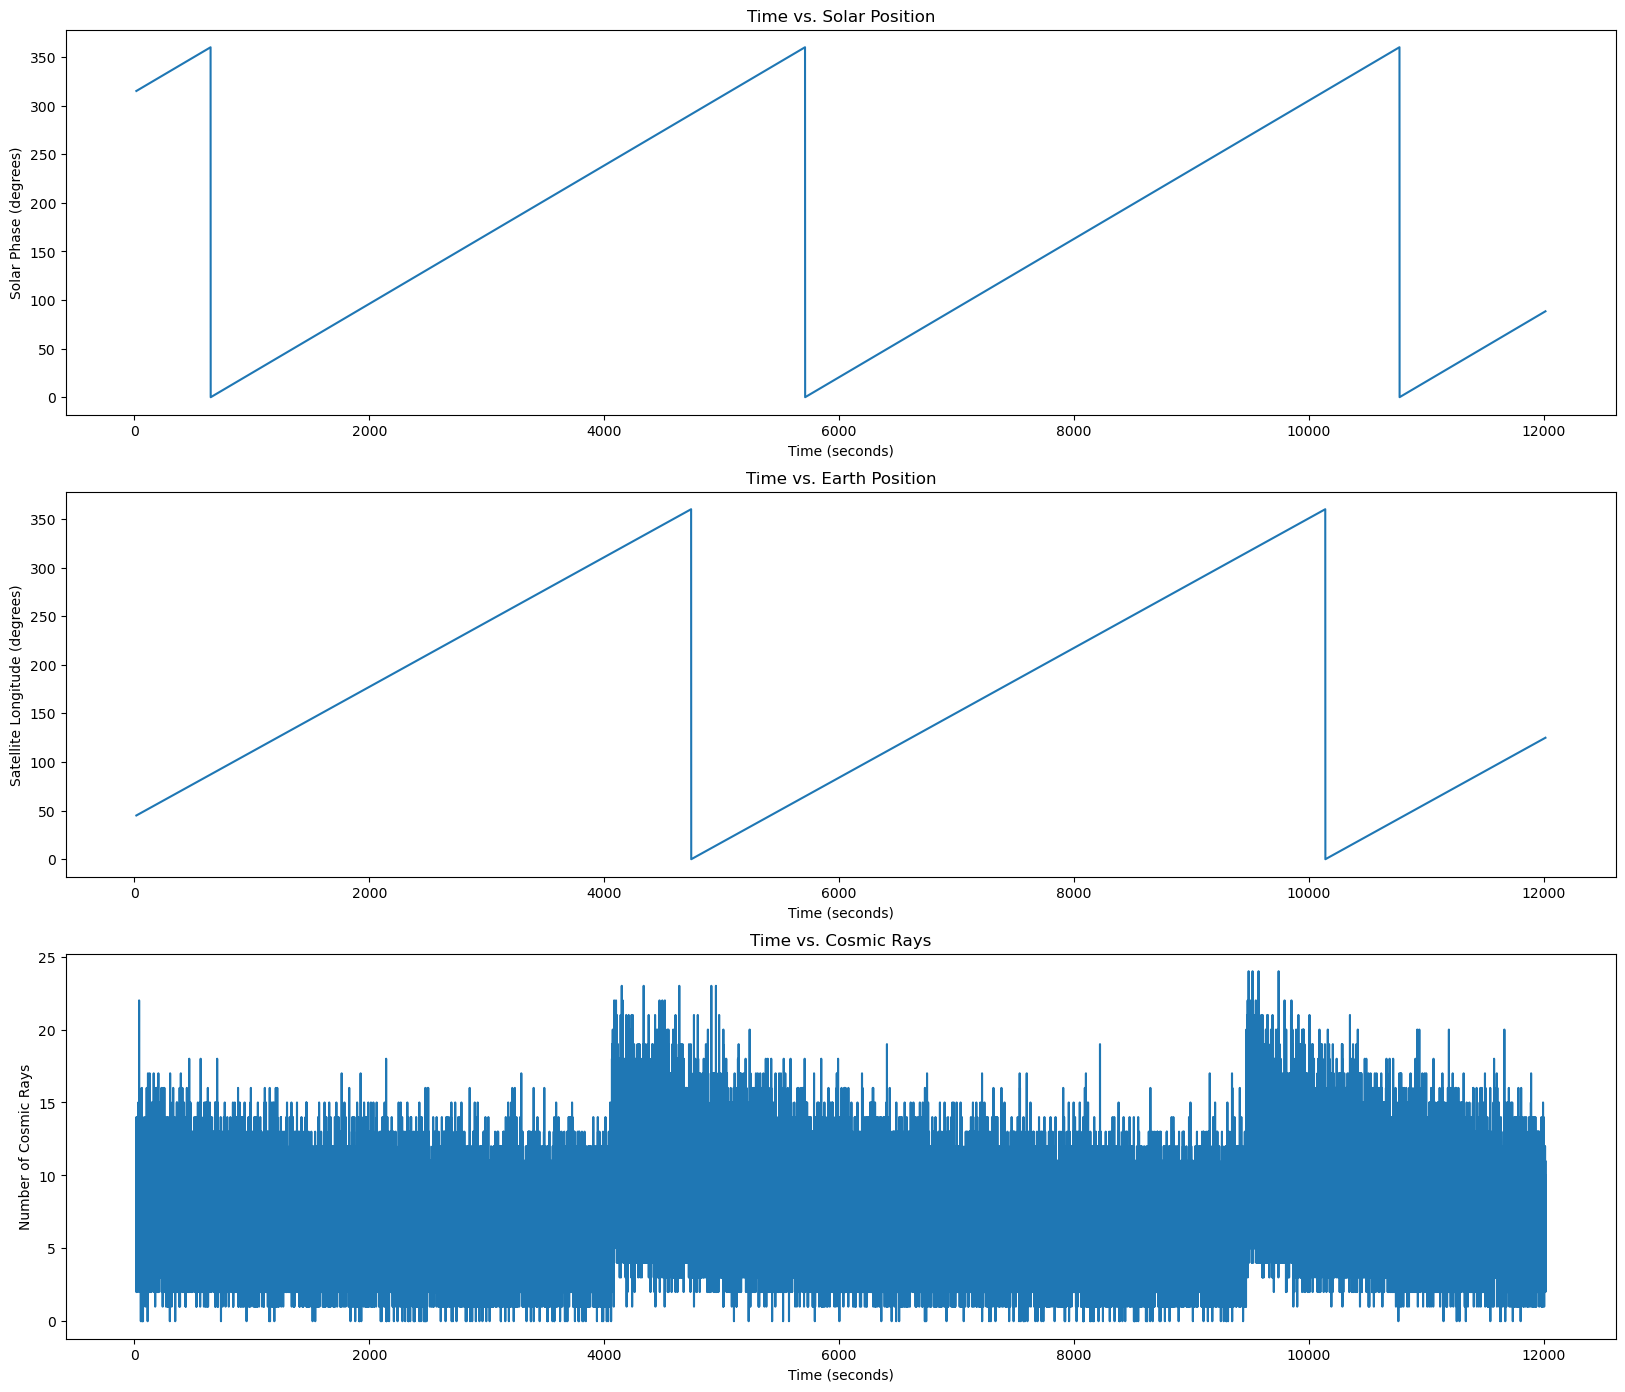

In [57]:
fig, ax = plt.subplots(3, 1, figsize = (20, 17))

graph(time, solar, 0, 12000, 10, 0)
ax[0].set_title("Time vs. Solar Position")
ax[0].set_xlabel("Time (seconds)")
ax[0].set_ylabel("Solar Phase (degrees)")

graph(time, earth, 0, 12000, 10, 1)
ax[1].set_title("Time vs. Earth Position")
ax[1].set_xlabel("Time (seconds)")
ax[1].set_ylabel("Satellite Longitude (degrees)")

graph(time, rays, 0, 12000, 1, 2)
ax[2].set_title("Time vs. Cosmic Rays")
ax[2].set_xlabel("Time (seconds)")
ax[2].set_ylabel("Number of Cosmic Rays")

These plots alone don't tells us much, so a density plot of gamma ray count vs. the other variables would be more helpful.

Text(0, 0.5, 'Number of Gamma Rays')

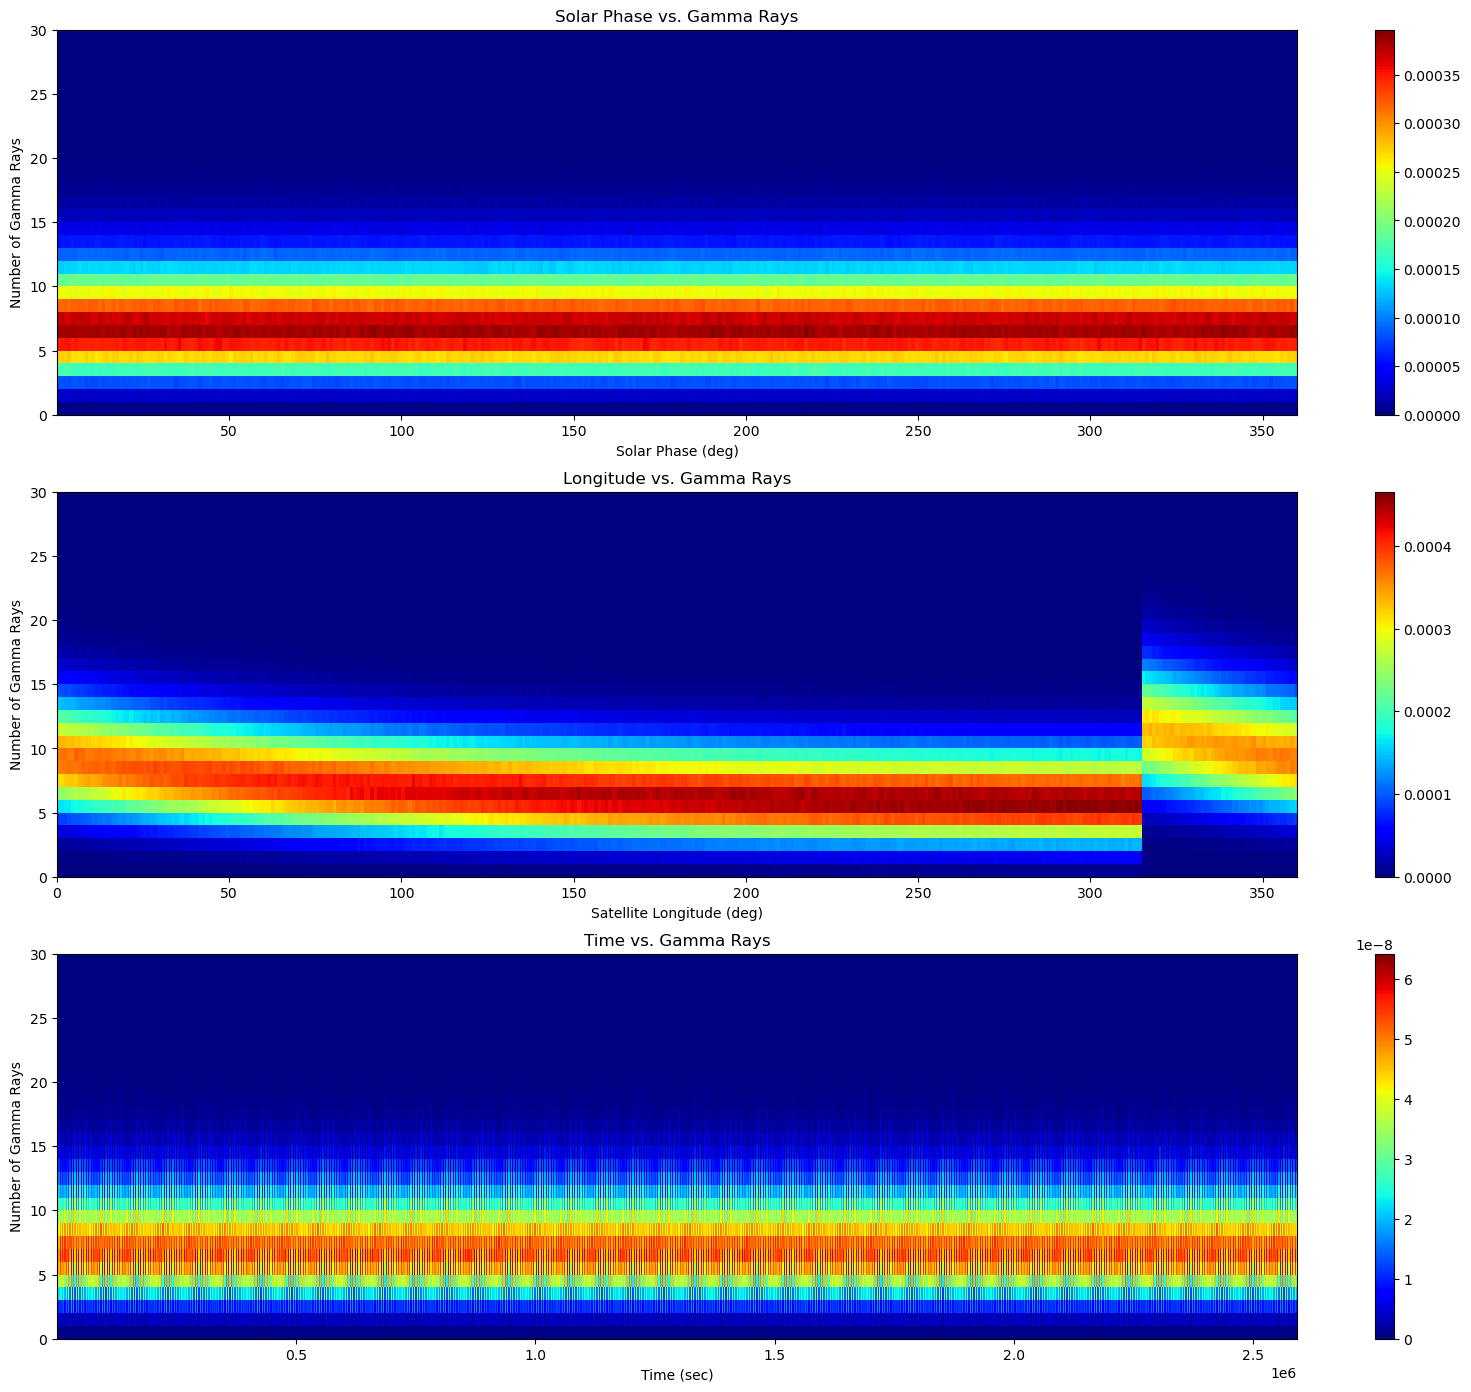

In [58]:
fig, ax = plt.subplots(3, 1, figsize = (20,17))

g = ax[0].hist2d(solar, rays, bins = [360,30], density = True, cmap = plt.cm.jet)
fig.colorbar(g[3], ax = ax[0])
ax[0].set_title("Solar Phase vs. Gamma Rays")
ax[0].set_xlabel("Solar Phase (deg)")
ax[0].set_ylabel("Number of Gamma Rays")

h = ax[1].hist2d(earth, rays, bins = [360,30], density = True, cmap = plt.cm.jet)
fig.colorbar(h[3], ax = ax[1])
ax[1].set_title("Longitude vs. Gamma Rays")
ax[1].set_xlabel("Satellite Longitude (deg)")
ax[1].set_ylabel("Number of Gamma Rays")

d = ax[2].hist2d(time, rays, bins = [1000,30], density = True, cmap = plt.cm.jet)
fig.colorbar(d[3], ax = ax[2])
ax[2].set_title("Time vs. Gamma Rays")
ax[2].set_xlabel("Time (sec)")
ax[2].set_ylabel("Number of Gamma Rays")

As you can see from the density plots above, gamma ray count only seems to correlate with the satellite's longitude. This would be giving us signal contamination from the longitude. So, we would like to find a way to account for this, i.e. a background distribution that is dependent on the longitude (or time, which the longitude is dependent on).
<br><br>
For the background pdf we want f(d), where f gives the ray count as a function of degrees longitude. We know gamma rays normally follow a Poisson distribution, so we need a Poisson for each degree, which boils down to finding the mean gamma rays at each degree (or the mean as a function of degree). This is done from the 2D histogram for longitude- look at each bin of the x-axis on the density plot to get the average of the y-bins.

Text(0, 0.5, 'Mean Gamma Ray Count')

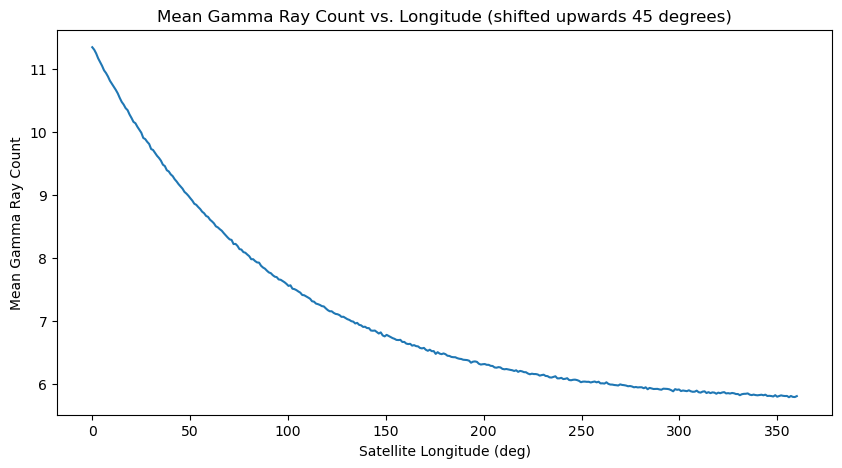

In [61]:
fig, ax = plt.subplots(1, 1, figsize = (10,5))

# maxes = []
# for i in range(len(h[1]) - 1):
#     prob_index = np.argmax(h[0][i])
#     maxes.append(prob_index)
    
g = h

means = []
for i in range(len(g[1]) - 1):
    g[0][i] = g[0][i] / np.sum(g[0][i])
    av = 0
    for n in range(len(g[0][i]) - 1):
        av = av + (g[0][i][n] * n)
    means.append(av)

index = 0
for i in range(len(means) - 1):
    if(means[i] >= max(means)):
        index = i
        break

shifted_means = means[0:index]
for i in range(len(means) - index):
    shifted_means.insert(0, means[len(means) - (i + 1)])


ax.plot(np.linspace(0, 360, 360), shifted_means)
ax.set_title("Mean Gamma Ray Count vs. Longitude (shifted upwards " + str(360 - index) + " degrees)")
ax.set_xlabel("Satellite Longitude (deg)")
ax.set_ylabel("Mean Gamma Ray Count")

The above is a graph of the mean gamma ray count vs. longitude (where the discontinuity that was seen in the 2D density histogram has been shifted to the left of the rest of the graph). From this we want to find a best fit.

[ 4.40286081e+00 -1.10982472e-02 -2.26766738e+01  5.69829256e+00]


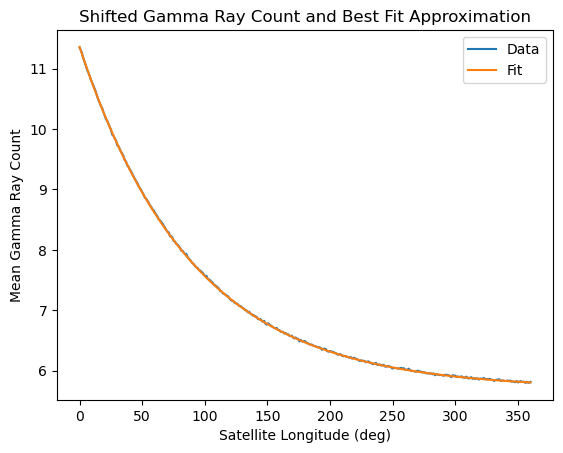

In [24]:
def fit(x, a, b, c, d):
    return a*np.exp(b*(x+c)) + d

guess_a = 5
guess_b = -0.01
guess_c = 15
guess_d = 6

init_guesses = [guess_a, guess_b, guess_c, guess_d]

fitpars, error = curve_fit(fit, np.arange(0, 360, 1), shifted_means, init_guesses)
print(fitpars)

fig, ax = plt.subplots(1, 1)

x = np.linspace(0, 360, 360)

f_x = fit(x, *fitpars)

def f_mean(x):
    return fitpars[0]*np.exp(fitpars[1]*(x+fitpars[2]))+fitpars[3]
    
ax.plot(x, shifted_means)
ax.plot(x, f_mean(x))
ax.set_title("Shifted Gamma Ray Count and Best Fit Approximation")
ax.set_xlabel("Satellite Longitude (deg)")
ax.set_ylabel("Mean Gamma Ray Count")
ax.legend(["Data", "Fit"])

This is the best fit of the shifted means. We used an exponential function for the fit, which (qualitatively) looks pretty accurate. Average number of gamma-rays: $f(d) = 6.032e^{-0.01*(x + 5.70)} + 5.70$ for degree (d). Using this we can pick whatever longitude we want and find the mean gamma ray count for that degree. We then plug this mean count into a Poisson distribution to get the background of that degree, from which we can find the 5 sigma value in the normal way (ppf function). Alternatively, because looking for a degree is the same as looking for a time in the table, we can also input a time into this and then just search the table for the wanted degree value (remembering to unshift the mean), as done below.

5 sigma thresholds for a 100ms GRB at a few (random) times- {4800: 27.0, 1000000: 23.0, 250670.1: 22.0}. Format = time (sec): threshold.


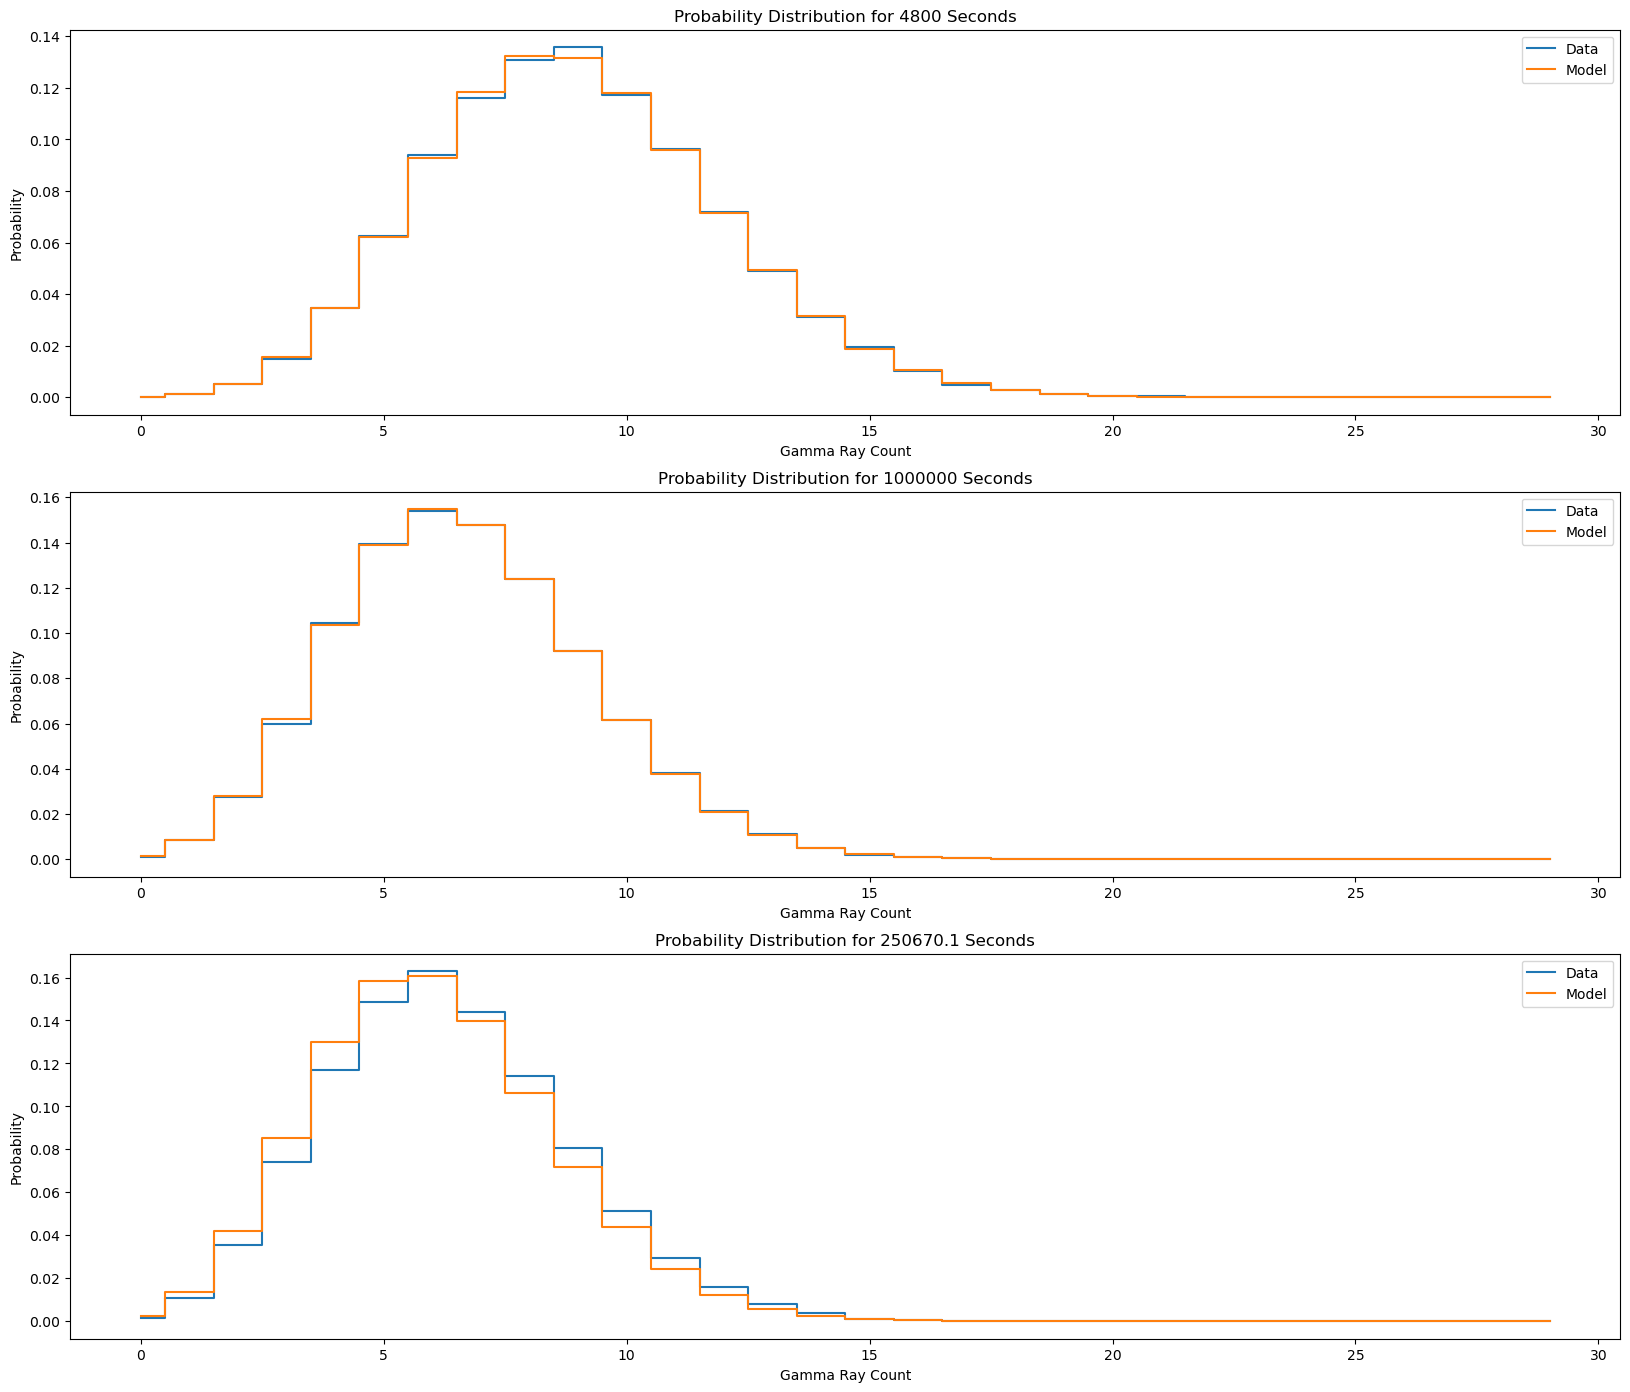

In [80]:
# Input a time (in seconds to the tenths place) to get the background model
# Starts at 0, not the actual GPS time

prob5sigma = stats.norm.cdf(5, loc = 0, scale = 1)
thresholds = dict()

def time_to_deg(time):
    return int(earth[int(time * 10)])

# Need to un-shift the mean corresponding to the wanted degree value 
def bkgd_model(time):
    return f_mean(earth[int(time * 10) + 150*45])
    
mu = bkgd_model(4000.1)

fig, ax = plt.subplots(3, 1, figsize = (20,17))
x = np.arange(0, 30, 1)

ax[0].step(x, h[0][time_to_deg(4800)], where = 'mid')
ax[0].step(x, stats.poisson.pmf(x, bkgd_model(4800), loc = 0), where = 'mid')
ax[0].legend(["Data", "Model"])
ax[0].set_title("Probability Distribution for 4800 Seconds")
ax[0].set_xlabel("Gamma Ray Count")
ax[0].set_ylabel("Probability")
thresholds[4800] = stats.poisson.ppf(prob5sigma, bkgd_model(4800), loc = 0)

ax[1].step(x, h[0][time_to_deg(1000000)], where = 'mid')
ax[1].step(x, stats.poisson.pmf(x, bkgd_model(1000000), loc = 0), where = 'mid')
ax[1].legend(["Data", "Model"])
ax[1].set_title("Probability Distribution for 1000000 Seconds")
ax[1].set_xlabel("Gamma Ray Count")
ax[1].set_ylabel("Probability")
thresholds[1000000] = stats.poisson.ppf(prob5sigma, bkgd_model(1000000), loc = 0)

ax[2].step(x, h[0][time_to_deg(250000)], where = 'mid')
ax[2].step(x, stats.poisson.pmf(x, bkgd_model(250670.1), loc = 0), where = 'mid')
ax[2].legend(["Data", "Model"])
ax[2].set_title("Probability Distribution for 250670.1 Seconds")
ax[2].set_xlabel("Gamma Ray Count")
ax[2].set_ylabel("Probability")
thresholds[250670.1] = stats.poisson.ppf(prob5sigma, bkgd_model(250670.1), loc = 0)

print("5 sigma thresholds for a 100ms GRB at a few (random) times- " + str(thresholds) + ". Format = time (sec): threshold.")

The model fits the data pretty well, showing relatively accurate distributions for these values.

# Problem 2

I am trying to find a transient among the ten images of the night sky provided. In these images there does not seem to be any signal contamination (images shown at end), especially because my signal should only show up in an image and so should get drowned out when averaged across all images. The background should be time independent and spatially consistent (the night sky does not change throughout time over the time the pictures were taken and is generally homogeneous). To look for stars I took a selection of the night sky background (meaning what a person would qualitatively see as just the night sky in these pictures, such as the top row or left-hand column in the first image, where it looks all black) and assumed that the natural variations in pixel intensity in this region followed a Gaussian distribution simply due to things like mechanical errors in the telescope or very slight color changes in the sky. From this assumption, I calculated the mean intensity and the standard deviation in this selection of the image and used these as parameters for the Gaussian. Using this Gaussian, I calculated what intensity value would be necessary for a 5 sigma significance (chosen arbitrarily as I don't know the typical value in astrophysics), then compared this significance value to the intensity of every pixel in every image to get a list of significant pixels. These significant pixels should correspond to bright spots in the sky (from whatever source, whether it be stars, supernovae, or otherwise). From this list of bright spots, I found which ones were only in one image to find the transients. For my selection of background data, I chose the left-hand column in all 10 images, giving me 2000 pixels to work with overall. From this, I averaged and found the standard deviation of each image separately, then averaged all the images together.
<br><br>

Possible transients at {'38 72': 1, '123 173': 0}. Format = 'y-pixel x-pixel': image number (image name - 1)


Text(0, 0.5, 'Probability')

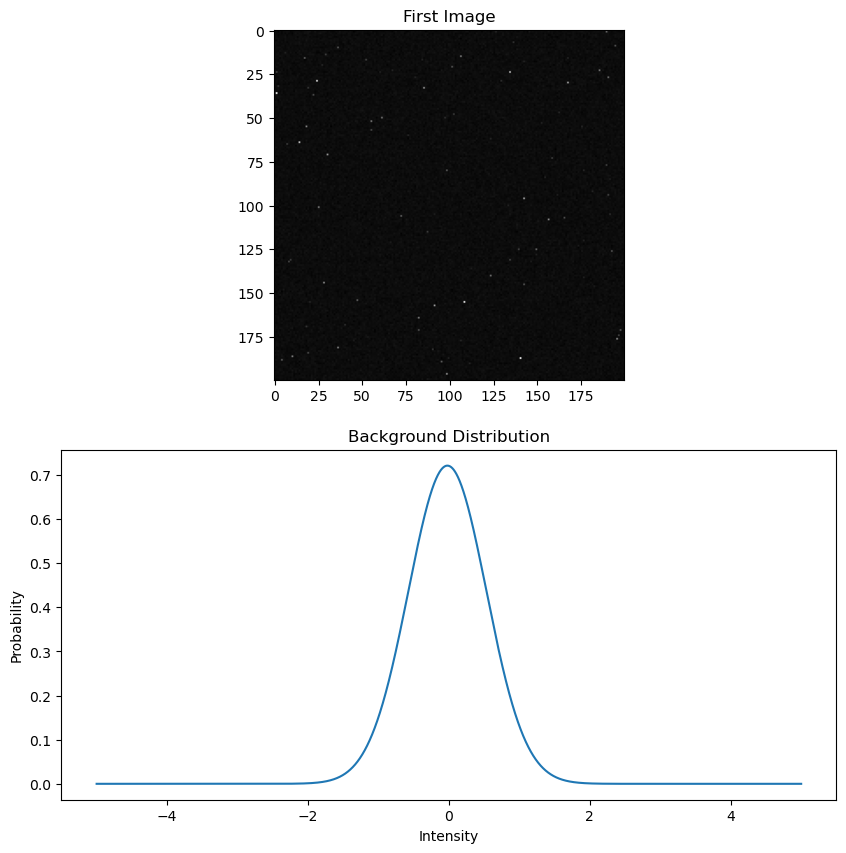

In [84]:
im = h5py.File('images.h5', 'r')
image1 = np.array(im.get('image1'))
imagestack = np.array(im.get('imagestack'))
# In Imagestack, the first index holds the y-value of the pixel, the second the x-index, the third the image (i.e. Imagestack[1][126][0] gives the 1st pixel from the top, 126th from the left,
# on the first image)

fig, ax = plt.subplots(2, 1, figsize = (10,10))
lin = np.linspace(-5, 5, 10000)

# Grab intensity values of the left-hand column in each picture
intensity = []
for i in range(len(imagestack[0][0])):
    intensity.append(imagestack[:,0,i])

# Averages and standard deviations for left-hand column of each picture
avs = []
std = []
for i in range(len(intensity)):
    avs.append(np.sum(intensity[i]) / len(intensity[i]))
    std.append(scipy.stats.tstd(intensity[i]))


# Overall averages and standard deviations
av_mean = np.sum(avs) / len(avs)
av_std = np.sum(std) / len(std)

# Gaussian and statistical significance values
bkgd_images = stats.norm.pdf(lin, loc = av_mean, scale = av_std)
prob5sigma = stats.norm.sf(5, loc = 0, scale = 1)
stat_sig = abs(stats.norm.ppf(prob5sigma, loc = av_mean, scale = av_std))


# ax[1].plot(lin, bkgd_images)


# Gathers which pixels are statistically significant
pixels = []
for i in range(len(imagestack[0])):
    for j in range(len(imagestack[0])):
        for n in range(len(imagestack[0][0])):
            if imagestack[i][j][n] >= stat_sig:
                pixels.append([i, j, n])

                
# Counts how many images each pixel appears in
pixel_count = dict()
for i in range(len(pixels)):
    current_pix = str(pixels[i][0]) + " " + str(pixels[i][1])
    if pixel_count.get(current_pix) is None:
        pixel_count[current_pix] = 1
    else:
        pixel_count[current_pix] = pixel_count.get(current_pix) + 1

        
# Creates a map of the pixels which occur in only one photo to the photo they appear in
poss_transients = dict()
for key in pixel_count:
    if pixel_count[key] <= 1:
        poss_transients[key] = None

for i in range(len(pixels)):
    for key in poss_transients:
        if(str(pixels[i][0]) + " " + str(pixels[i][1]) == key):
            poss_transients[key] = pixels[i][2]
    
print("Possible transients at " + str(poss_transients) + ". Format = 'y-pixel x-pixel': image number (image name - 1)")

ax[0].imshow(imagestack[:,:,0], cmap = 'gray')
ax[0].set_title("First Image")
ax[1].plot(lin, bkgd_images)
ax[1].set_title("Background Distribution")
ax[1].set_xlabel("Intensity")
ax[1].set_ylabel("Probability")

I found two transients based on my classifications, in images 1 (0) and 2 (1). Looking for a transient like this would give a different background than faint stars because in looking for transients, the faint stars are part of the background, meaning I don't have to worry about them contaminating the signal (brighter stars are a little different as they could shift the background drastically, making it easier to miss things which are short in duration). What you would look for is also different in both cases- here I looked for something in *one* image, whereas you want to see faint stars *consistently*.

All images plotted below for reference/comparison.

Text(0.5, 1.0, 'Tenth Image')

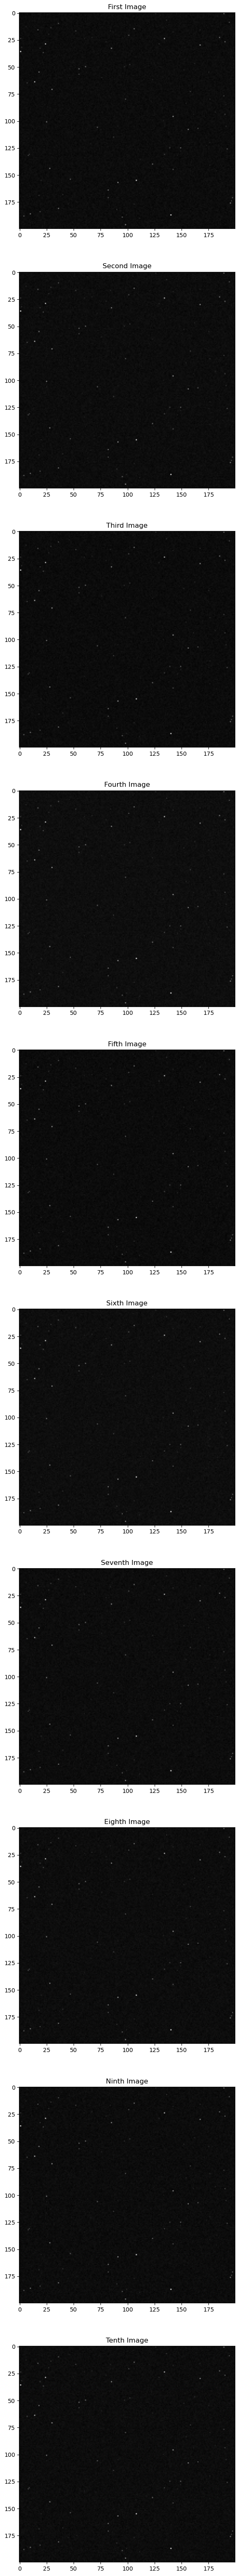

In [55]:
fig, ax = plt.subplots(10, 1, figsize = (80,80))

ax[0].imshow(imagestack[:,:,0], cmap = 'gray')
ax[0].set_title("First Image")

ax[1].imshow(imagestack[:,:,1], cmap = 'gray')
ax[1].set_title("Second Image")

ax[2].imshow(imagestack[:,:,2], cmap = 'gray')
ax[2].set_title("Third Image")

ax[3].imshow(imagestack[:,:,3], cmap = 'gray')
ax[3].set_title("Fourth Image")

ax[4].imshow(imagestack[:,:,4], cmap = 'gray')
ax[4].set_title("Fifth Image")

ax[5].imshow(imagestack[:,:,5], cmap = 'gray')
ax[5].set_title("Sixth Image")

ax[6].imshow(imagestack[:,:,6], cmap = 'gray')
ax[6].set_title("Seventh Image")

ax[7].imshow(imagestack[:,:,7], cmap = 'gray')
ax[7].set_title("Eighth Image")

ax[8].imshow(imagestack[:,:,8], cmap = 'gray')
ax[8].set_title("Ninth Image")

ax[9].imshow(imagestack[:,:,9], cmap = 'gray')
ax[9].set_title("Tenth Image")